## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [4]:
# If you didn't download it yet, please get the relevant file now!
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

--2020-11-10 14:23:24--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Risoluzione di www.dropbox.com (www.dropbox.com)... 162.125.69.1, 2620:100:6025:1::a27d:4501
Connessione a www.dropbox.com (www.dropbox.com)|162.125.69.1|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 301 Moved Permanently
Posizione: /s/raw/xvjzaxzz3ysphme/data_000637.txt [segue]
--2020-11-10 14:23:25--  https://www.dropbox.com/s/raw/xvjzaxzz3ysphme/data_000637.txt
Riutilizzo della connessione esistente a www.dropbox.com:443.
Richiesta HTTP inviata, in attesa di risposta... 302 Found
Posizione: https://ucabf383b233f79ae4aeff96545e.dl.dropboxusercontent.com/cd/0/inline/BC4MsgBl79WnE_Jgo_EwBiB4Iozlug9TG2T4SZUQZNx1uZzcVEg_gC7zlRPyVaXz0vsQHDS0yLYUhToX-g8-SG0CsbyYeU0lpTmoXwUQVFCbqT0vND5eqttL0enWAJ9yN3Q/file# [segue]
--2020-11-10 14:23:25--  https://ucabf383b233f79ae4aeff96545e.dl.dropboxusercontent.com/cd/0/inline/BC4MsgBl79WnE_Jgo_EwBiB4Iozlug9TG2T4SZUQZNx1uZzcVEg_gC7zlRPyVaXz0vsQHDS0yLYU

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [1]:
import pandas as pd
import numpy as np
file_name="~/data/data_000637.txt"
N = 12000
data=pd.read_csv(file_name)
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14
1310716,1,1,4,3869211171,763,11
1310717,1,0,64,3869211171,764,0
1310718,1,0,139,3869211171,769,0


In [23]:
print("X is:", data['BX_COUNTER'].max())

X is: 3563


3. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

In [22]:
time0 =  data['TDC_MEAS'][0]*(25/30)+data['BX_COUNTER'][0]*25*(25/30)+(25/30)*25*3564*data['ORBIT_CNT'][0]
timefinal = data['TDC_MEAS'][1310719]*(25/30)+data['BX_COUNTER'][1310719]*25*(25/30)+(25/30)*25*3564*data['ORBIT_CNT'][1310719]
timefinal -time0

817013410.0

4. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

In [20]:
data['ABS_TIME'] = data['TDC_MEAS']*(25/30)+data['BX_COUNTER']*25*(25/30)+(25/30)*25*3564*data['ORBIT_CNT']
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,ABS_TIME
0,1,0,123,3869200167,2374,26,2.872881e+14
1,1,0,124,3869200167,2374,27,2.872881e+14
2,1,0,63,3869200167,2553,28,2.872881e+14
3,1,0,64,3869200167,2558,19,2.872881e+14
4,1,0,64,3869200167,2760,25,2.872881e+14
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,2.872889e+14
1310716,1,1,4,3869211171,763,11,2.872889e+14
1310717,1,0,64,3869211171,764,0,2.872889e+14
1310718,1,0,139,3869211171,769,0,2.872889e+14


5. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

In [60]:
data['HEAD'] = np.random.randint(0,2, size=len(data))
data

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14
1310716,0,1,4,3869211171,763,11
1310717,0,0,64,3869211171,764,0
1310718,1,0,139,3869211171,769,0


6. Create a new DataFrame that contains only the rows with HEAD=1.

In [35]:
newDataFrame = data[data['HEAD']==1]
newDataFrame

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14
1310716,1,1,4,3869211171,763,11
1310717,1,0,64,3869211171,764,0
1310718,1,0,139,3869211171,769,0


7. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

<BarContainer object of 132 artists>

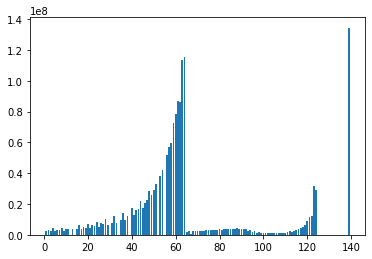

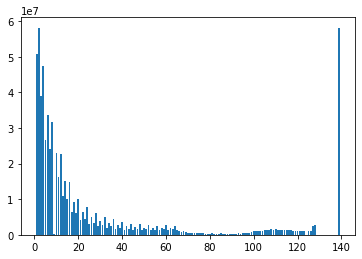

In [11]:
import matplotlib.pyplot as plt
data=pd.read_csv(file_name)
unique_channels_0 = data[data['FPGA']==0]['TDC_CHANNEL'].unique()
unique_channels_1 = data[data['FPGA']==1]['TDC_CHANNEL'].unique()
listCounts0 = []
listCounts1 = []
for channel in unique_channels_0:
    nrcounts = data[(data['FPGA']==0) & (data['TDC_CHANNEL']==channel)]['BX_COUNTER'].sum()
    listCounts0.append((channel,nrcounts))
for channel in unique_channels_1:
    nrcounts = data[(data['FPGA']==1) & (data['TDC_CHANNEL']==channel)]['BX_COUNTER'].sum()
    listCounts1.append((channel,nrcounts))
len(listCounts0),len(listCounts1)
plt.figure()
plt.bar(*zip(*listCounts0))
plt.figure()
plt.bar(*zip(*listCounts1))

8. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

In [12]:
data=pd.read_csv(file_name) 
noisyChannelsFPGA0 = data[data['FPGA']==0].groupby('TDC_CHANNEL').size().sort_values(ascending=False)[:3]
noisyChannelsFPGA1 =data[data['FPGA']==1].groupby('TDC_CHANNEL').size().sort_values(ascending=False)[:3]
noisyChannelsFPGA0,noisyChannelsFPGA1

(TDC_CHANNEL
 139    75617
 64     64581
 63     63724
 dtype: int64,
 TDC_CHANNEL
 2      32669
 139    32442
 1      28438
 dtype: int64)

9. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

In [10]:
data=pd.read_csv(file_name)
len(data[data['TDC_CHANNEL'] == 139]['ORBIT_CNT'].unique())

10976